# Sentiment Analysis E-Commerce Product Reviews NLP


![](https://traid.org.uk/wp-content/uploads/2019/02/1800_eac.jpg)

This is a classic NLP problem dealing with data from an e-commerce store focusing on women's clothing, and based on the customer reviews we have to predict if each of them was a positive or negative recomendation.

---
---


- Experiment 1: Basic NLP Count based Features & Age, Feedback Count
  - Training a Logistic Regression Model
  - Model Evaluation Metrics - Quick Refresher
- Experiment 2: Features from Sentiment Analysis
  - Leveraging Text Sentiment
  - Model Training and Evaluation
- Text Pre-processing and Wrangling
- Experiment 3: Modeling based on Bag of Words based Features - 1-grams
  - Use the following default config for count vectorizer
  - Model Training and Evaluation
- Experiment 4: Modeling with Bag of Words based Features - 2-grams
  - Model Training and Evaluation
- Experiment 5: Adding Bag of Words based Features - 3-grams
  - Model Training and Evaluation
- Experiment 6: Adding Bag of Words based Features - 3-grams with Feature Selection
- Experiment 7: Combining Bag of Words based Features - 3-grams with Feature Selection and the Structured Features
  - Coverting dense features into sparse format
  - Combine the features using `hstack`
  - Model Training and Evaluation
- Experiment 8: Modeling on FastText Averaged Document Embeddings
  - Generate document level embeddings
  - Model Training and Evaluation
- Experiment 9: Combine FastText Vectors + Structured Features and build a model
  - Model Training and Evaluation
- Experiment 10: Train Classfier with CNN + FastText Embeddings & Evaluate Performance on Test Data
- Experiment 11: Train Classfier with LSTM + FastText Embeddings & Evaluate Performance on Test Data
- Experiment 12: Train Classfier with NNLM Universal Embedding Model
- Experiment 13: Train Classfier with BERT


# Load up basic dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm

     |████████████████████████████████| 106 kB 14.9 MB/s 
     |████████████████████████████████| 284 kB 31.3 MB/s 


# Load and View the Dataset

The data is available at https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews from where you can download it.

In [31]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [33]:
df = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv', keep_default_na=False)
df = df.drop(columns=["Unnamed: 0"])
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# Basic Data Processing

- Merge all review text attributes (title, text description) into one attribute
- Subset out columns of interest

In [34]:
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Age', 'Positive Feedback Count', 'Recommended']]
df.head()

# # Day 4
# df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
# df['Recommended'] = df['Recommended IND']
# df = df[['Review', 'Recommended']]
# df.head()

,Review,Age,Positive Feedback Count,Recommended
0,Absolutely wonderful - silky and sexy and comf...,33,0,1
1,Love this dress! it's sooo pretty. i happene...,34,4,1
2,Some major design flaws I had such high hopes ...,60,0,0
3,"My favorite buy! I love, love, love this jumps...",50,0,1
4,Flattering shirt This shirt is very flattering...,47,6,1


## Remove all records with no review text

In [35]:
df = df[df['Review'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22642 entries, 0 to 23485
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Review                   22642 non-null  object
 1   Age                      22642 non-null  int64 
 2   Positive Feedback Count  22642 non-null  int64 
 3   Recommended              22642 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 884.5+ KB


## There is some imbalance in the data based on product recommendations

In [36]:
df['Recommended'].value_counts()

1    18541
0     4101
Name: Recommended, dtype: int64

# Build train and test datasets

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((15849, 3), (6793, 3))

In [38]:
from collections import Counter
Counter(y_train), Counter(y_test)

(Counter({0: 2883, 1: 12966}), Counter({0: 1218, 1: 5575}))

In [39]:
X_train.head(3)

,Review,Age,Positive Feedback Count
4654,Sexy and flows I love this jumpsuit! i'm usual...,79,8
5333,Wanted to love it The dresss is much shorter t...,32,3
22502,So cute! though inside not soft I got the crea...,34,0


In [40]:
y_train[:3]

4654     1
5333     0
22502    1
Name: Recommended, dtype: int64

# Experiment 1: Basic NLP Count based Features & Age, Feedback Count

A number of basic text based features can also be created which sometimes are helpful for improving text classification models. 
Some examples are:

- __Word Count:__ total number of words in the documents
- __Character Count:__ total number of characters in the documents
- __Average Word Density:__ average length of the words used in the documents
- __Puncutation Count:__ total number of punctuation marks in the documents
- __Upper Case Count:__ total number of upper count words in the documents
- __Title Word Count:__ total number of proper case (title) words in the documents

In [41]:
import string

X_train['char_count'] = X_train['Review'].apply(len)
X_train['word_count'] = X_train['Review'].apply(lambda x: len(x.split()))
X_train['word_density'] = X_train['char_count'] / (X_train['word_count']+1)
X_train['punctuation_count'] = X_train['Review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
X_train['title_word_count'] = X_train['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X_train['upper_case_word_count'] = X_train['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


X_test['char_count'] = X_test['Review'].apply(len)
X_test['word_count'] = X_test['Review'].apply(lambda x: len(x.split()))
X_test['word_density'] = X_test['char_count'] / (X_test['word_count']+1)
X_test['punctuation_count'] = X_test['Review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
X_test['title_word_count'] = X_test['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X_test['upper_case_word_count'] = X_test['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [42]:
X_train.head()

,Review,Age,Positive Feedback Count,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
4654,Sexy and flows I love this jumpsuit! i'm usual...,79,8,469,95,4.885417,17,2,1
5333,Wanted to love it The dresss is much shorter t...,32,3,144,26,5.333333,4,2,0
22502,So cute! though inside not soft I got the crea...,34,0,451,93,4.797872,14,2,1
392,Lovely fabric but tiny hips If your hips are b...,34,0,396,83,4.714286,6,2,0
372,"So cool This has great drape, length, the patt...",57,1,292,56,5.122807,10,2,0


## Training a Logistic Regression Model 

A logistic regression model is easy to train, interpret and works well on a wide variety of NLP problems

In [43]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1, random_state=42, solver='lbfgs', max_iter=1e4)

## Model Evaluation Metrics - Quick Refresher

Just accuracy is never enough in datasets with a rare class problem.

- __Precision:__ The positive predictive power of a model. Out of all the predictions made by a model for a class, how many are actually correct
- __Recall:__ The coverage or hit-rate of a model. Out of all the test data samples belonging to a class, how many was the model able to predict (hit or cover) correctly.
- __F1-score:__ The harmonic mean of the precision and recall

In [44]:
lr.fit(X_train.drop(['Review'], axis=1), y_train)
predictions = lr.predict(X_test.drop(['Review'], axis=1))

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[   1 1217]
 [   2 5573]]
              precision    recall  f1-score   support

           0       0.33      0.00      0.00      1218
           1       0.82      1.00      0.90      5575

    accuracy                           0.82      6793
   macro avg       0.58      0.50      0.45      6793
weighted avg       0.73      0.82      0.74      6793



You will probably get a really bad model here meaning the features were completely useless! 

First, lets drop those not so useful features.

In [45]:
X_train.drop(['char_count', 'word_count', 'word_density', 
              'punctuation_count', 'title_word_count', 'upper_case_word_count'], axis=1, inplace=True)
X_test.drop(['char_count', 'word_count', 'word_density', 
              'punctuation_count', 'title_word_count', 'upper_case_word_count'], axis=1, inplace=True)

# Experiment 2: Features from Sentiment Analysis 

## Leveraging Text Sentiment

Reviews are pretty subjective, opinionated and people often express stong emotions, feelings. 
This makes it a classic case where the text documents here are a good candidate for extracting sentiment as a feature.

The general expectation is that highly rated and recommended products (__label 1__) should have a __positive__ sentiment and products which are not recommended (__label 0__) should have a __negative__ sentiment.

TextBlob is an excellent open-source library for performing NLP tasks with ease, including sentiment analysis. It also an a sentiment lexicon (in the form of an XML file) which it leverages to give both polarity and subjectivity scores. 

- The polarity score is a float within the range [-1.0, 1.0]. 
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. 

Perhaps this could be used for getting some new features?

Basic examples here.

Source: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [46]:
import textblob

textblob.TextBlob('This is an AMAZING pair of Jeans!').sentiment

Sentiment(polarity=0.7500000000000001, subjectivity=0.9)

In [47]:
textblob.TextBlob('I really hated this UGLY T-shirt!!').sentiment

Sentiment(polarity=-0.95, subjectivity=0.85)

Remember this is unsupervised, lexicon-based sentiment analysis where we don't have any pre-labeled data saying which review migth have a positive or negative sentiment. We use the lexicon to determine this.

In [48]:
x_train_snt_obj = X_train['Review'].apply(lambda row: textblob.TextBlob(row).sentiment)
X_train['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
X_train['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]

x_test_snt_obj = X_test['Review'].apply(lambda row: textblob.TextBlob(row).sentiment)
X_test['Polarity'] = [obj.polarity for obj in x_test_snt_obj.values]
X_test['Subjectivity'] = [obj.subjectivity for obj in x_test_snt_obj.values]

In [49]:
X_train.head()

,Review,Age,Positive Feedback Count,Polarity,Subjectivity
4654,Sexy and flows I love this jumpsuit! i'm usual...,79,8,0.237380,0.641259
5333,Wanted to love it The dresss is much shorter t...,32,3,0.260000,0.400000
22502,So cute! though inside not soft I got the crea...,34,0,0.180093,0.562963
392,Lovely fabric but tiny hips If your hips are b...,34,0,0.114286,0.610440
372,"So cool This has great drape, length, the patt...",57,1,0.321667,0.721111


## Model Training and Evaluation

In [50]:
lr.fit(X_train.drop(['Review'], axis=1), y_train)
predictions = lr.predict(X_test.drop(['Review'], axis=1))

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 210 1008]
 [ 119 5456]]
              precision    recall  f1-score   support

           0       0.64      0.17      0.27      1218
           1       0.84      0.98      0.91      5575

    accuracy                           0.83      6793
   macro avg       0.74      0.58      0.59      6793
weighted avg       0.81      0.83      0.79      6793



You will probably get a better model than Experiment 1

# Text Pre-processing and Wrangling

We want to extract some specific features based on standard NLP feature engineering models like the classic Bag of Words model.
For this we need to clean and pre-process our text data. We will build a simple text pre-processor here since the main intent is to look at feature engineering strategies.

We will focus on:
- Text Lowercasing
- Removal of contractions
- Removing unnecessary characters, numbers and symbols
- Stopword removal

Source: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [51]:
import contractions

contractions.fix('I didn\'t like this t-shirt')

'I did not like this t-shirt'

In [52]:
import nltk
import contractions
import re
import tqdm

# remove some stopwords to capture negation in n-grams if possible
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('no')
stopwords.remove('not')
stopwords.remove('but')


def normalize_document(doc):
    # fix contractions
    doc = contractions.fix(doc)
    # remove special characters and digits
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, flags=re.I|re.A)
    # lower case
    doc = doc.lower()
    # strip whitespaces
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stopwords]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

In [53]:
X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

100%|██████████| 6793/6793 [00:03<00:00, 2171.88it/s]


## Let's remove the review column now since we don't need it anymore and restructure our dataframes

In [54]:
X_train = X_train[['Clean Review', 'Age', 'Positive Feedback Count', 'Polarity', 'Subjectivity']]
X_test = X_test[['Clean Review', 'Age', 'Positive Feedback Count', 'Polarity', 'Subjectivity']]

X_train.head()

,Clean Review,Age,Positive Feedback Count,Polarity,Subjectivity
4654,sexy flows love jumpsuit usually size small ho...,79,8,0.237380,0.641259
5333,wanted love dresss much shorter described see ...,32,3,0.260000,0.400000
22502,cute though inside not soft got cream color ab...,34,0,0.180093,0.562963
392,lovely fabric but tiny hips hips bigger size u...,34,0,0.114286,0.610440
372,cool great drape length pattern super versatil...,57,1,0.321667,0.721111


## Extracting out the structured features from previous experiments

__We will extract out the structured columns \ features so we can use them right at the end after doing a few experiments with bag of words__

`X_train_struct` and `X_test_struct` should contain only 4 columns i.e.

- Age
- Positive Feedback Count
- Polarity
- Subjectivity

In [55]:
X_train_struct = X_train.drop(['Clean Review'], axis=1).reset_index(drop=True)
X_test_struct = X_test.drop(['Clean Review'], axis=1).reset_index(drop=True)

X_train_struct.head()

,Age,Positive Feedback Count,Polarity,Subjectivity
0,79,8,0.237380,0.641259
1,32,3,0.260000,0.400000
2,34,0,0.180093,0.562963
3,34,0,0.114286,0.610440
4,57,1,0.321667,0.721111


# Experiment 3: Modeling based on Bag of Words based Features - 1-grams

This is perhaps the most simple vector space representational model for unstructured text. A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute. 

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. 

The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

Source: https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41

In [56]:
train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']

## Use the following default config for count vectorizer

- `min_df` as 0.0
- `max_df` as 1.0
- `ngram_range` as (1,1)

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

X_traincv = cv.fit_transform(train_clean_text)
X_testcv = cv.transform(test_clean_text)

In [58]:
X_traincv

<15849x15490 sparse matrix of type '<class 'numpy.int64'>'
	with 445775 stored elements in Compressed Sparse Row format>

## Model Training and Evaluation

In [59]:
lr.fit(X_traincv, y_train)
predictions = lr.predict(X_testcv)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 801  417]
 [ 258 5317]]
              precision    recall  f1-score   support

           0       0.76      0.66      0.70      1218
           1       0.93      0.95      0.94      5575

    accuracy                           0.90      6793
   macro avg       0.84      0.81      0.82      6793
weighted avg       0.90      0.90      0.90      6793



This should look promising and far better that the previous models if you did it correctly

Can we still improve on our model? Let's look at n-grams!

# Experiment 4: Modeling with Bag of Words based Features - 2-grams

We use the same feature engineering technique here except we consider both 1 and 2-grams as our features. 

In [60]:
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 2))

X_traincv = cv.fit_transform(train_clean_text)
X_testcv = cv.transform(test_clean_text)

In [61]:
X_traincv

<15849x227749 sparse matrix of type '<class 'numpy.int64'>'
	with 930126 stored elements in Compressed Sparse Row format>

## Model Training and Evaluation

In [62]:
lr.fit(X_traincv, y_train)
predictions = lr.predict(X_testcv)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 821  397]
 [ 215 5360]]
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      1218
           1       0.93      0.96      0.95      5575

    accuracy                           0.91      6793
   macro avg       0.86      0.82      0.84      6793
weighted avg       0.91      0.91      0.91      6793



You should be able to see some minor improvements

# Experiment 5: Adding Bag of Words based Features - 3-grams 

We use the same feature engineering technique here except we consider 1, 2 and 3-grams as our features.

In [63]:
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 3))

X_traincv = cv.fit_transform(train_clean_text)
X_testcv = cv.transform(test_clean_text)

In [64]:
X_traincv

<15849x640659 sparse matrix of type '<class 'numpy.int64'>'
	with 1402090 stored elements in Compressed Sparse Row format>

## Model Training and Evaluation

In [65]:
lr.fit(X_traincv, y_train)
predictions = lr.predict(X_testcv)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 811  407]
 [ 193 5382]]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73      1218
           1       0.93      0.97      0.95      5575

    accuracy                           0.91      6793
   macro avg       0.87      0.82      0.84      6793
weighted avg       0.91      0.91      0.91      6793



# Experiment 6: Adding Bag of Words based Features - 3-grams with Feature Selection

Set `min_df` as 3 in CountVectorizer and keep other params same as the previous experiment and notice the drop in features.

We drop all words \ n-grams which occur less than 3 times in all documents.

How will the model perform now?

In [66]:
cv = CountVectorizer(min_df=3, max_df=1., ngram_range=(1, 3))

X_traincv = cv.fit_transform(train_clean_text)
X_testcv = cv.transform(test_clean_text)

In [67]:
X_traincv

<15849x44449 sparse matrix of type '<class 'numpy.int64'>'
	with 762144 stored elements in Compressed Sparse Row format>

In [68]:
lr.fit(X_traincv, y_train)
predictions = lr.predict(X_testcv)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 833  385]
 [ 235 5340]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1218
           1       0.93      0.96      0.95      5575

    accuracy                           0.91      6793
   macro avg       0.86      0.82      0.84      6793
weighted avg       0.91      0.91      0.91      6793



# Experiment 7: Combining Bag of Words based Features - 3-grams with Feature Selection and the Structured Features

Let's combine our sparse BOW feature matrices with our structured features from earlier.

We do need to convert those structured features into sparse format so we can concatenate them to the BOW features!

In [69]:
X_train_struct.values

array([[ 7.90000000e+01,  8.00000000e+00,  2.37379630e-01,
         6.41259259e-01],
       [ 3.20000000e+01,  3.00000000e+00,  2.60000000e-01,
         4.00000000e-01],
       [ 3.40000000e+01,  0.00000000e+00,  1.80092593e-01,
         5.62962963e-01],
       ...,
       [ 3.20000000e+01,  0.00000000e+00,  1.10185185e-01,
         4.76851852e-01],
       [ 3.00000000e+01,  1.00000000e+00, -1.85185185e-03,
         3.91666667e-01],
       [ 3.40000000e+01,  9.00000000e+00, -1.84000000e-01,
         6.90000000e-01]])

## Coverting dense features into sparse format

In [70]:
from scipy import sparse

In [71]:
sparse.csr_matrix(X_train_struct)

<15849x4 sparse matrix of type '<class 'numpy.float64'>'
	with 56141 stored elements in Compressed Sparse Row format>

In [72]:
X_traincv

<15849x44449 sparse matrix of type '<class 'numpy.int64'>'
	with 762144 stored elements in Compressed Sparse Row format>

## Combine the features using `hstack`

Check documentation if needed, it should be straightforward

In [73]:
from scipy.sparse import hstack

X_train_combined = hstack([sparse.csr_matrix(X_train_struct), 
                           X_traincv])
X_test_combined = hstack([sparse.csr_matrix(X_test_struct), X_testcv])

In [74]:
X_train_combined

<15849x44453 sparse matrix of type '<class 'numpy.float64'>'
	with 818285 stored elements in COOrdinate format>

## Model Training and Evaluation

In [75]:
lr.fit(X_train_combined, y_train)
predictions = lr.predict(X_test_combined)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 847  371]
 [ 238 5337]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1218
           1       0.94      0.96      0.95      5575

    accuracy                           0.91      6793
   macro avg       0.86      0.83      0.84      6793
weighted avg       0.91      0.91      0.91      6793



# Experiment 8: Modeling on FastText Averaged Document Embeddings

## Build the FastText embedding model here

Remember more the iterations usually better the embeddings but the more time it will take depending on your system CPU / GPU

In [76]:
%%time

from gensim.models import FastText

tokenized_docs_train = [doc.split() for doc in train_clean_text]
# sample config params size: 300, window: 30, min_count=2 or more, iter=10
ft_model = FastText(tokenized_docs_train, size=300, window=30, min_count=2, workers=4, sg=1, iter=10)

CPU times: user 7min 42s, sys: 698 ms, total: 7min 43s
Wall time: 3min 58s


## Generate document level embeddings

Word embedding models give us an embedding for each word, how can we use it for downstream ML\DL tasks? one way is to flatten it or use sequential models. A simpler approach is to average all word embeddings for words in a document and generate a fixed-length document level embedding

In [77]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [78]:
tokenized_docs_train = [doc.split() for doc in train_clean_text]
tokenized_docs_test = [doc.split() for doc in test_clean_text]

Xtrain_doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs_train, ft_model, 300)
Xtest_doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs_test, ft_model, 300)

Xtrain_doc_vecs_ft.shape

(15849, 300)

## Model Training and Evaluation

In [79]:
lr.fit(Xtrain_doc_vecs_ft, y_train)
predictions = lr.predict(Xtest_doc_vecs_ft)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 745  473]
 [ 164 5411]]
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      1218
           1       0.92      0.97      0.94      5575

    accuracy                           0.91      6793
   macro avg       0.87      0.79      0.82      6793
weighted avg       0.90      0.91      0.90      6793



# Experiment 9: Combine FastText Vectors + Structured Features and build a model

In [80]:
X_train_combined = np.concatenate((X_train_struct, Xtrain_doc_vecs_ft),axis=1)
X_test_combined = np.concatenate((X_test_struct, Xtest_doc_vecs_ft),axis=1)

## Model Training and Evaluation

In [81]:
lr.fit(X_train_combined, y_train)
predictions = lr.predict(X_test_combined)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 768  450]
 [ 169 5406]]
              precision    recall  f1-score   support

           0       0.82      0.63      0.71      1218
           1       0.92      0.97      0.95      5575

    accuracy                           0.91      6793
   macro avg       0.87      0.80      0.83      6793
weighted avg       0.90      0.91      0.90      6793



# Experiment 10: Train Classfier with CNN + FastText Embeddings

__Note:__ Skip FastText Embeddings part if it takes too much time to download or load it since it does consume a good amount of memory to load the pretrained embeddings.

If you want to load pre-trained embeddings use a slightly smaller file than the one we used in live-coding which had over 2 million words. Here is the link to get embeddings from facebook's pre-trained fasttext model.

https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


In [82]:
train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']

In [83]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(train_clean_text)
t.word_index['<PAD>'] = 0

In [84]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('orderingreturning', 15508) ('<PAD>', 0) 1


In [85]:
train_sequences = t.texts_to_sequences(train_clean_text)
test_sequences = t.texts_to_sequences(test_clean_text)

In [86]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=15509
Number of Documents=15849


In [87]:
max(len(i) for i in train_sequences)

65

In [88]:
max(len(doc.split()) for doc in train_clean_text)

65

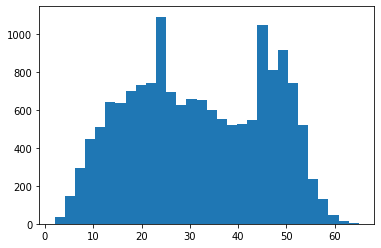

In [89]:
plt.hist([len(item) for item in train_sequences], bins=30);

In [90]:
MAX_SEQUENCE_LENGTH = 121

# pad dataset to a maximum review length in words
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_seqs.shape, test_seqs.shape

((15849, 121), (6793, 121))

In [91]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=32

In [92]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2022-02-27 11:43:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  23.4MB/s    in 29s     

2022-02-27 11:44:27 (22.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [93]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [94]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [95]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(15509, 300)

In [96]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 121, 300)          4652700   
                                                                 
 conv1d (Conv1D)             (None, 121, 256)          307456    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 64)            3

In [97]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_seqs, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
446/446 [==============================] - 16s 10ms/step - loss: 0.2722 - accuracy: 0.8824 - val_loss: 0.2145 - val_accuracy: 0.9079
Epoch 2/100
446/446 [==============================] - 4s 10ms/step - loss: 0.1568 - accuracy: 0.9385 - val_loss: 0.2128 - val_accuracy: 0.9091
Epoch 3/100
446/446 [==============================] - 4s 10ms/step - loss: 0.0937 - accuracy: 0.9649 - val_loss: 0.2420 - val_accuracy: 0.9098
Epoch 4/100
446/446 [==============================] - 4s 9ms/step - loss: 0.0501 - accuracy: 0.9830 - val_loss: 0.4166 - val_accuracy: 0.9028
Epoch 4: early stopping


In [99]:
predictions = (model.predict(test_seqs) > 0.5).astype("int")

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1218
           1       0.95      0.94      0.95      5575

    accuracy                           0.91      6793
   macro avg       0.84      0.87      0.85      6793
weighted avg       0.92      0.91      0.91      6793



,0,1
0,968,250
1,348,5227


# Experiment 11: Train Classfier with LSTM + FastText Embeddings

In [100]:
LSTM_DIM = 256

# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

#model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 121, 300)          4652700   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [104]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_seqs, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
446/446 [==============================] - 7s 16ms/step - loss: 0.1725 - accuracy: 0.9319 - val_loss: 0.2513 - val_accuracy: 0.9028
Epoch 2/100
446/446 [==============================] - 7s 16ms/step - loss: 0.1105 - accuracy: 0.9577 - val_loss: 0.2773 - val_accuracy: 0.8927
Epoch 3/100
446/446 [==============================] - 7s 16ms/step - loss: 0.0668 - accuracy: 0.9750 - val_loss: 0.3530 - val_accuracy: 0.8953
Epoch 4/100
446/446 [==============================] - 7s 16ms/step - loss: 0.0401 - accuracy: 0.9851 - val_loss: 0.5109 - val_accuracy: 0.8896
Epoch 5/100
446/446 [==============================] - 7s 16ms/step - loss: 0.0332 - accuracy: 0.9884 - val_loss: 0.6055 - val_accuracy: 0.8921
Epoch 6/100
446/446 [==============================] - 7s 16ms/step - loss: 0.0207 - accuracy: 0.9924 - val_loss: 0.6914 - val_accuracy: 0.8801
Epoch 6: early stopping


In [103]:
predictions = (model.predict(test_seqs) > 0.5).astype("int")

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1218
           1       0.95      0.93      0.94      5575

    accuracy                           0.91      6793
   macro avg       0.83      0.86      0.85      6793
weighted avg       0.91      0.91      0.91      6793



,0,1
0,968,250
1,395,5180


# Experiment 12: Train Classfier with NNLM Universal Embedding Model


In [105]:
model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)

In [106]:
model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 124,741,761
Trainable params: 124,741,76

In [107]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_clean_text, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
446/446 [==============================] - 19s 40ms/step - loss: 0.2592 - accuracy: 0.8852 - val_loss: 0.2380 - val_accuracy: 0.8934
Epoch 2/100
446/446 [==============================] - 18s 40ms/step - loss: 0.1614 - accuracy: 0.9344 - val_loss: 0.2434 - val_accuracy: 0.8883
Epoch 3/100
446/446 [==============================] - 17s 37ms/step - loss: 0.1151 - accuracy: 0.9532 - val_loss: 0.3507 - val_accuracy: 0.8833
Epoch 3: early stopping


In [109]:
predictions = (model.predict(test_clean_text) > 0.5).astype("int")

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1218
           1       0.92      0.97      0.94      5575

    accuracy                           0.91      6793
   macro avg       0.86      0.80      0.83      6793
weighted avg       0.90      0.91      0.90      6793



,0,1
0,766,452
1,185,5390


# Experiment 13: Train Classfier with BERT

##### Note: You might need to restart the notebook environment on colab after installing the below library

In [ ]:
!pip install transformers --ignore-installed

In [111]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df = df[df['Review'] != '']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)

import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']

100%|██████████| 6793/6793 [00:00<00:00, 14786.92it/s]


#### Train and Evaluate your BERT model using `transformers`

In [112]:
import transformers

In [113]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [114]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [115]:
MAX_SEQ_LENGTH = 121

In [116]:
inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 121)]        0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 121)]        0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 121)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]',   

In [117]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_clean_text, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 15849/15849 [00:30<00:00, 525.67it/s]


In [118]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], y_train, 
          validation_split=0.1,
          epochs=3, 
          batch_size=25, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/3
571/571 [==============================] - 257s 417ms/step - loss: 0.2363 - accuracy: 0.8987 - val_loss: 0.1735 - val_accuracy: 0.9192
Epoch 2/3
571/571 [==============================] - 234s 410ms/step - loss: 0.1387 - accuracy: 0.9431 - val_loss: 0.1928 - val_accuracy: 0.9205
Epoch 2: early stopping


In [119]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_clean_text, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 6793/6793 [00:42<00:00, 161.32it/s]


Test Features: (6793, 121) (6793, 121) (6793, 121)


In [120]:
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1218
           1       0.96      0.96      0.96      5575

    accuracy                           0.93      6793
   macro avg       0.89      0.88      0.88      6793
weighted avg       0.93      0.93      0.93      6793



,0,1
0,972,246
1,222,5353
